# FEniCS simulation of a cantilever beam

The aim of this notebook is to setup a very simple FEniCS simulation. The framework is linear, plane strain elasticity. We model a cantilever beam ($L$: total length; $d$: depth), subjected to its own weight ($\rho$: mass density per unit volume; $g$: gravity).

The beam is homogenous and isotropic ($E$: Young modulus; $\nu$: Poisson ratio) and clamped on the left end. Hooke's law reads

\begin{equation}
\sigma_{ij} = \lambda\varepsilon_{kk}\delta_{ij}+2\mu\varepsilon_{ij},
\end{equation}

where indices $i, j, k$ are restricted to $\{1, 2\}$ and $\lambda$, $\mu$ are the Lamé coefficients :

\begin{equation*}
\mu=\frac{E}{2\bigl(1+\nu\bigr)}
\quad\text{and}\quad
\lambda=\frac{2\mu\nu}{1-2\nu}.
\end{equation*}

**Question:** how does Hooke's law read in *plane stress* elasticity?

The variational formulation of the problem is the following:

Find $u\in \mathcal{C}\equiv\{u: H^1(\Omega), \; u(x_1=0,x_2)=0\}$ such that 
$\forall v\in \mathcal{C}_0\equiv \mathcal{C}$


\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y =
-\int_{\Omega}\rho g\,e_y\cdot v\,\mathrm{d} x\,\mathrm{d} y,
\end{equation}

where $\sigma(\varepsilon)$ is the constitutive equation and $\varepsilon(u)=\mathrm{sym} (\nabla u)$  

Remark: we work with only one unknown vector field, the displacement $u_x(x_1,x_2)$

![image of beam](cantilever_beam.png "Cantilever beam")

In [1]:
import dolfin
# from fenics import *

import matplotlib.pyplot as plt
import numpy as np

## 1) Start with defining the mesh

In [2]:
# geometry and mesh 
L = 1.    # total length
d = L/20. # thickness
h = d/16. # size of a cell

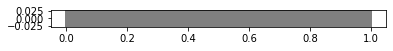

In [57]:
# Building the mesh

nx1  = nx2 = 50
mesh = dolfin.RectangleMesh(dolfin.Point(0, -d/2), dolfin.Point(L, d/2), nx1, nx2)

dolfin.plot(mesh)

## 2) Choose an element (Lagrange of degree 1)

In [58]:
# Build basis function

V = dolfin.VectorFunctionSpace(mesh, 'Lagrange', 1)

## 3) Define the stress

$u_i$ is  the displacement vector (note: $u=u(x_1,x_2)$)

and 

$\epsilon_{ij} = \frac12\bigl(\partial_i u_j+\partial_j u_i\bigr)$ is the stress tensor.

In [59]:
# tensor epsilon

def epsilon(u):
    
    """ Function returning deformation epsilon provided variable u """
    
    epsilon = .5 * (dolfin.grad(u) + dolfin.nabla_grad(u))
    
    return epsilon

## 4) Write down Hooke's law

In [60]:
# here we use the values
E    = 1.0
nu   = 0.3

mu   = .5 * (E / (1 + nu))
lamb = 2*mu * nu / (1 - 2*nu)

# Hook's law is written as the top of this notebook
def sigma(u):
    
    """ Function returning stress sigma provided variable epsilon (deformation tensor) """
    
    sigma = lamb * dolfin.div(u) * dolfin.Identity(2) + 2*mu * epsilon(u)
    
    return sigma

## 5) Name `u` the `TrialFunction` and `v` the `TestFunction`

In [61]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

## 6) Introduce the bilinear form

\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y
\end{equation}

What is the difference between `dolfin.dot( )` and `dolfin.inner( )` ?

$\underline{Response}$ : dolfin.inner works for both tensors and vectors while dolfin.dot works to build vectors only.

In [62]:
a = dolfin.inner(sigma(u), epsilon(v))*dolfin.dx

## 7) Introduce the linear form

\begin{equation}
-\int_{\Omega}\rho g\,e_y\cdot v\,\mathrm{d} x\,\mathrm{d} y.
\end{equation}

In [63]:
# here we use the value
g   = 1. # adimensionate gravity
rho = 1. # adimensionate volumic mass of the structure

f = dolfin.Constant((0, -rho*g))
l = dolfin.dot(f, v)*dolfin.dx

## 8)  Boundary conditions

Dirichelet Boundary Condition: $u(0,x_2)=0 \quad  \forall x_2 \in [-\frac{d}{2},\frac{d}{2}]$

As $x_1=0$ is not well defined in our mesh, we write 

$u(x_1,x_2)=0 \quad \forall x_1 \ll L  \text{ and } \forall x_2 \in [-\frac{d}{2},\frac{d}{2}]$


In [64]:
# define boundary x=0

clamped    = 'near(x[0], 0)' #close to x[0]==0. Maybe must include a tolerence factor ??

BC_clamped = dolfin.DirichletBC(V, dolfin.Constant((0,0)), clamped)

## 9) Solving the discretized problem

In [65]:
# We introduce the solution we are looking as a Function 

usol = dolfin.Function(V)

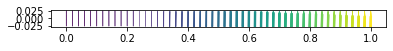

In [66]:
# And we solve the linear problem using 

dolfin.solve(a == l, usol, BC_clamped)

# dolfin.plot(mesh)
dolfin.plot(usol)

## 10) Using linear beam theory, we plot the vertical deflection of the solution 

$$H(x_1)=u_2(x_1,0)$$

In [67]:
# we introduce the coefficients
D     = E/(1.-nu**2) * d**3/12. #E*I #bending rigidity of an elastic plate

k     = .2 # unknown coefficient that we want to find (it is not equal to 0.2)
v_max = k*g*d/D # maximum vertical deflection, from linear 'beam' theory 

$$ H(x_1) = H_\text{max} \, \left ( - \frac{1}{3} \, x_1^4 - \frac{4}{3} \, x_1 + \frac{1}{3} \right) $$

### Analytical deflection

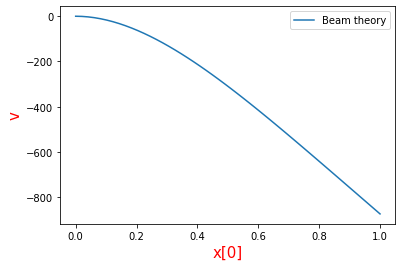

In [68]:
x     = np.linspace(0., L, num=50)
v_ana = v_max * (-1./3.*(x-1.)**4 - 4./3.*x + 1/3)

plt.plot(x, v_ana, label='Beam theory')
plt.xlabel('x[0]',color='red',fontsize=15)
plt.ylabel('v',color='red',fontsize=15)
plt.legend()

### Numerical deflection

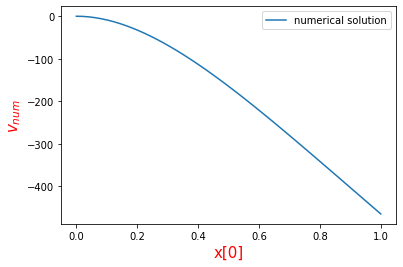

In [76]:
v_num = np.array([usol(_,0) for _ in x]) #from dolfin to array

plt.plot(x, v_num[:,1], label='numerical solution')

plt.title('Numerical deflection obtained through FEniCS, using Lagrange order 1 basis functions')
plt.xlabel('x[0]',       color='red', fontsize=15)
plt.ylabel(r'$v_{num}$', color='red', fontsize=15)

plt.legend()

As both graph don't fit initially, we look for coefficient k that best fit numerical result from analytical formula.

## 11) On this plot, we add the plot of the numerically found  $u_2(x_1,0)$ and we change the value of $k$ for the two plots to coincide

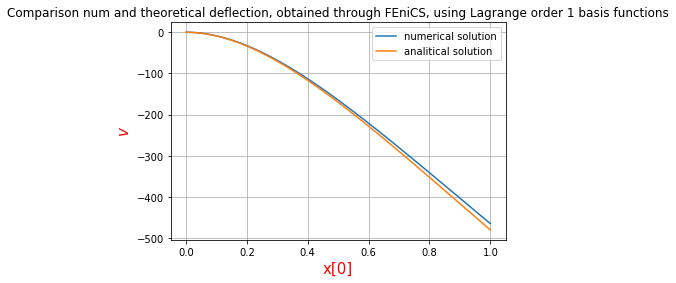

In [82]:
def v_ana(k):

    """ Function testing different coefficient k to fit 
    numerical solution u_num from analytical solution u_ana """
    
    x     = np.linspace(0, L, num=50)
    v_max = k * g*d/D #with g, d & D given
    
    v_ana = v_max * (-1./3.*(x-1.)**4 - 4./3.*x + 1/3)
    
    return v_ana

# ------------------------------------------------------
# Find factor k minimizing the L2 error

size_error = 100
error_L2   = np.zeros((size_error))

k          = np.array([1/size_error * _ for _ in range(size_error)])

for i in range(np.size(k)):
        
    error_L2[i] = np.linalg.norm(v_ana(k[i]) - v_num[:,1])

idx  = np.where(error_L2==np.min(error_L2))

# --------------------------------------------
# check if we found the good k

plt.plot(x, v_num[:,1], x, v_ana(k[idx]))

plt.title('Comparison num and theoretical deflection, \
obtained through FEniCS, using Lagrange order 1 basis functions')

plt.xlabel('x[0]',       color='red', fontsize=15)
plt.ylabel(r'$v$', color='red', fontsize=15)

plt.legend(['numerical solution', 'analitical solution'])
plt.grid(True)

$\Rightarrow$ The solution best feet when :
* the order of basis function is higher (quadratic $\rightarrow$ cubic $\rightarrow$ etc)
* the number of grid points : more grid points, more continuity so the code might solve closer to reality ??

## 12) We plot the deformed beam, hanging under its own weight

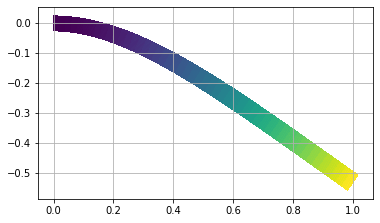

In [83]:
# instead of plotting usol, we plot usol/Hmax with the correct value of k
dolfin.plot(usol/v_max, mode='displacement')

plt.grid(True)

$\Rightarrow$ **To conclude, using FEniCS, we have been able to get numerical displacement of the beam both along $x[0]$ and $x[1]$.
Then, provided the analytical solution of verical deflection of the beam under its own weight, we compared both results. An application may be that if one doesn't entirely know the analytical solution, we here get this variable through energy minimization.**

**In another context, instead of comparing analytical to numeric, one can compare analytical to experimental and see the factor for which exp$\approx$analytical function.**